#**Req packages**

In [1]:
!pip install langchain_core langchain_community langgraph langchain_groq langchain_huggingface langchain-chroma


##**Load env variables**

In [3]:
# import os
# from dotenv import load_dotenv
# load_dotenv()

# groq_api_key=os.getenv("GROQ_API_KEY")
# hf_token=os.getenv("HF_TOKEN")


In [9]:
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
groq_api_key = userdata.get('groq_api_key')

##**imports**

In [29]:
# graph and agent state
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator

# core message types
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

# model and embedding
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings

# Search tool
# from langchain_community.tools.tavily_search import TavilySearchResults

##**LLM and Embedding Model**

In [11]:
# llm model
llm=ChatGroq(groq_api_key=groq_api_key,
             model="llama-3.3-70b-versatile")

# embedding model
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#**RAG**

In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

##**Data loader & text splitter**

In [24]:
loader = TextLoader("/content/indian_economy.txt")
docs = loader.load()

# text splitter
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)

doc_splits = text_splitter.split_documents(documents=docs)

len(doc_splits)

54

In [25]:
doc_strings  = [doc.page_content for doc in doc_splits]

In [26]:
db = Chroma.from_documents(doc_splits, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [27]:
query = "Tell me about India's Industrial Growth?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': '/content/indian_economy.txt'}
India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': '/content/indian_economy.txt'}
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': '/content/indian_economy.txt'}
page_content='Industrial Revival and Economic Optimism for India' metadata={'source': '/content/indian_economy.txt'}


<ipython-input-27-68696cffbb4e>:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


#**LangGraph**

In [32]:
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser


##**Agent State**

In [31]:
class AgentState(TypedDict):
      messages: Annotated[list[AnyMessage], operator.add]

##**Agent Node**

####**Pydantic Class**

In [33]:
from pydantic import BaseModel , Field

class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [34]:
parser = PydanticOutputParser(pydantic_object = TopicSelectionParser)

In [46]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


####**Topic Selection function**

In [35]:
def Topic_selection(state : AgentState):
    message=state["messages"]
    question=message[-1]
    print(question)

    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related].
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()
                                        })
    # chain
    chain =  prompt | llm | parser

    response = chain.invoke({"question":question, "format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [47]:
state={"messages": ["Tell me about India's Industrial Growth"]}
Topic_selection(state)

Tell me about India's Industrial Growth
Topic='India' Reasoning="The user query mentions India's Industrial Growth, which is directly related to the country."


{'messages': ['India']}

##**RAG Node**

In [36]:
def RAG_function(state):
    print('-> Calling RAG ->')
    messages = state['messages']

    # get the user question
    question = messages[0]
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )

    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

##**LLM node**

In [37]:
def LLM_function(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Answer the following question. Here is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

##**Router Conditional edge**

In [38]:
def router(state : AgentState):
    print('-> Router ->')

    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

##**Final Graph**

In [40]:
# instant from StateGraph
graph = StateGraph(AgentState)

# Create nodes
graph.add_node("agent", Topic_selection)
graph.add_node("RAG", RAG_function)
graph.add_node("LLM", LLM_function)

# set entry point
graph.set_entry_point("agent")

#S et conditional edges
graph.add_conditional_edges("agent", router,        # condition at agent node using router function
                              {
                                  "RAG Call": "RAG",
                                  "LLM Call": "LLM",
                              }
                            )


# Set edges
graph.add_edge("RAG",END)
graph.add_edge("LLM",END)


app = graph.compile()

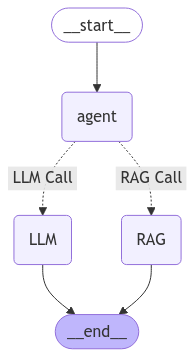

In [42]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

#**Test examples**

In [43]:
inputs = {"messages": ["Tell me about India's Industrial Growth"]}
output = app.invoke(inputs)


Tell me about India's Industrial Growth
Topic='India' Reasoning="The user query mentions India's Industrial Growth which is directly related to India"
-> Router ->
India
-> Calling RAG ->
Tell me about India's Industrial Growth
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]


In [44]:
inputs = {"messages": ["tell me about Mohamed Salah"]}
output = app.invoke(inputs)


tell me about Mohamed Salah
Topic='Not Related' Reasoning='The query is about Mohamed Salah, an Egyptian footballer, and does not relate to India.'
-> Router ->
Not Related
-> Calling LLM ->


In [45]:
output

{'messages': ['tell me about Mohamed Salah',
  'Not Related',
  "Mohamed Salah is a highly skilled Egyptian professional footballer who plays as a forward for the English Premier League club Liverpool and the Egypt national team. He is widely regarded as one of the best players in the world.\n\n**Early Life and Career**\n\nMohamed Salah was born on June 15, 1992, in Nagrig, Egypt. He began his youth career at El Mokawloon SC, a local club in Egypt, before joining Basel in Switzerland in 2012. His impressive performances at Basel caught the attention of Chelsea, who signed him in 2014.\n\n**Chelsea and Loan Spells**\n\nSalah's time at Chelsea was limited, and he was loaned out to Fiorentina and Roma in Italy. During his loan spell at Roma, he impressed the club's management and eventually made a permanent move to the Italian capital in 2016.\n\n**Liverpool and Success**\n\nIn 2017, Salah joined Liverpool for a then-club-record fee of £36.9 million. His transfer to Anfield proved to be a